# Q2 - Regression analysis: NHL goals

Use Bayes Rule and Multinomial Regressions to estimate the in-game winning probability in terms of the home team

The likehood that a home team win will eventually win the game can be expressed as

$$ p(W_g| score_{g,t} ) = \frac{p(g_g| SX_{g,t} ) p(W_g)}{ p(SX_{g,t} | W_g) p(W_g) +  p(SX_{g,t} | \overline{W_g}) p( \overline{W_g}) } $$

where the subscript $g$ denotes the game and $t$ denotes minutes remaining in regulation time. The following terms denote:

* $p(W_g| SX_{g,t})$: the posterior probability of a win the $g^th$ game with $t$ minutes remaining 
* $p(W_g$: the prior probability of a win
* $p(SX_{g,t} |W_g)$ and $p(SX_{g,t}  | \overline{W_g})$: inverse conditional probabilities


* Provide an in game winning probability plot for game number 21202

## Data
* The unit of observation is a season-game-goal
* The secstart column is the number of seconds from the start of the game
* The hgoals and agoals columns are the number of goals scored for by the home and away team prior at time $t$


In [2]:
import os
import sys
import pandas
import numpy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import statsmodels.api as sm

pandas.set_option('display.notebook_repr_html', True)
pandas.set_option('display.max_columns', 40)
pandas.set_option('display.max_rows', 25)
pandas.set_option('precision', 4)

C:\ProgramData\Anaconda3\envs\my_root\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dm = pandas.read_csv('NHLSeasonGameGoals.csv')
dm.head()

,gamedate,season,gameno,goalno,period,secstart,gteam,hteam,ateam,wteam,hgoals,agoals
0,2014-12-22,2014,20500,1,1,394,home,VAN,ARI,home,0,0
1,2014-12-22,2014,20500,2,1,1037,home,VAN,ARI,home,1,0
2,2014-12-22,2014,20500,3,1,1158,home,VAN,ARI,home,2,0
3,2014-12-22,2014,20500,4,2,1301,home,VAN,ARI,home,3,0
4,2014-12-22,2014,20500,5,2,1939,home,VAN,ARI,home,4,0


### Sort dataframe
* season-game-goal observations

In [19]:
dm = dm.sort_values(by=['season', 'gameno', 'goalno'])
dm.head()

,gamedate,season,gameno,goalno,period,secstart,gteam,hteam,ateam,wteam,hgoals,agoals,dgoals,minstart
0,2014-12-22,2014,20500,1,1,394,home,VAN,ARI,home,0,0,0,6
1,2014-12-22,2014,20500,2,1,1037,home,VAN,ARI,home,1,0,1,17
2,2014-12-22,2014,20500,3,1,1158,home,VAN,ARI,home,2,0,2,19
3,2014-12-22,2014,20500,4,2,1301,home,VAN,ARI,home,3,0,3,21
4,2014-12-22,2014,20500,5,2,1939,home,VAN,ARI,home,4,0,3,32


### Create column

In [50]:
dm['dgoals'] = dm.hgoals - dm.agoals
dm['dgoals'] = numpy.where(dm.dgoals>3, 3, dm.dgoals)
dm['dgoals'] = numpy.where(dm.dgoals<-3, -3, dm.dgoals)

dm['minstart'] = (dm.secstart/60).astype('int')

dm['secrem'] = 3600 - dm.secstart
dm['lnsecrem'] = numpy.log(dm['secrem'])

## Summary statistics

In [52]:
dm.describe()

,season,gameno,goalno,period,secstart,hgoals,agoals,dgoals,minstart,secrem,lnsecrem
count,3615.0,3615.0000,3615.0000,3615.0000,3615.0000,3615.0000,3615.0000,3615.0000,3615.0000,3615.0000,3615.0000
mean,2014.0,20846.0965,3.5087,2.0769,1922.4539,1.3959,1.1950,0.1734,31.5452,1677.5461,7.0245
std,0.0,203.8264,2.0776,0.8030,1038.4533,1.4037,1.2225,1.4402,17.2979,1038.4533,1.1971
min,2014.0,20500.0000,1.0000,1.0000,60.0000,0.0000,0.0000,-3.0000,1.0000,1.0000,0.0000
25%,2014.0,20669.0000,2.0000,1.0000,1053.5000,0.0000,0.0000,-1.0000,17.0000,783.0000,6.6631
50%,2014.0,20841.0000,3.0000,2.0000,1933.0000,1.0000,1.0000,0.0000,32.0000,1667.0000,7.4188
75%,2014.0,21019.5000,5.0000,3.0000,2817.0000,2.0000,2.0000,1.0000,46.0000,2546.5000,7.8425
max,2014.0,21202.0000,12.0000,3.0000,3599.0000,8.0000,6.0000,3.0000,59.0000,3540.0000,8.1719


### Dataframes: home win and home loss

In [53]:
d1 = dm[dm.wteam=='home']
d0 = dm[dm.wteam=='away']

In [44]:
y1 = d0.groupby('minstart', as_index=False)['dgoals'].mean()
x = list(range(1,60))
print(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


## Score margin summary analysis

In [54]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_notebook
output_notebook()

TOOLS = 'pan,wheel_zoom,box_zoom,reset,save,box_select'

y1 = d1.groupby('minstart')['dgoals'].mean()
y0 = d0.groupby('minstart')['dgoals'].mean()
x = list(range(1, 60))

p1 = figure(title='Mean point differential throughout the progression of games.', 
            x_range=[0,60], y_range=[-3, 3], 
            x_axis_label = 'Minutes from game start', y_axis_label = 'Goal differential', tools=TOOLS)

p1.line(x, y1, color='navy', alpha=1, line_width=3, legend='Home team wins')
p1.line(x, y0, color='firebrick', alpha=1, line_width=3, legend='Home team losses')
p1.ray([0], [0], color='black', length=300, angle=0, line_width=1)
p1.legend.location = 'bottom_left'
show(gridplot(p1, ncols=1, nrows=1, plot_width=800, plot_height=500))

Loading BokehJS ...

### Estimate inverse conditional probabilities

In [56]:
m1 = sm.MNLogit(d1.dgoals, sm.add_constant(d1.lnsecrem)).fit()
m0 = sm.MNLogit(d0.dgoals, sm.add_constant(d0.lnsecrem)).fit()

Optimization terminated successfully.
         Current function value: 1.554964
         Iterations 10
Optimization terminated successfully.
         Current function value: 1.480198
         Iterations 11


### MNL regression results: possession team wins

In [57]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 dgoals   No. Observations:                 2003
Model:                        MNLogit   Df Residuals:                     1991
Method:                           MLE   Df Model:                            6
Date:                Mon, 02 Apr 2018   Pseudo R-squ.:                 0.04351
Time:                        22:36:01   Log-Likelihood:                -3114.6
converged:                       True   LL-Null:                       -3256.3
                                        LLR p-value:                 3.036e-58
==============================================================================
 dgoals=-2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6451      4.294      0.616      0.538      -5.771      11.061
lnsecrem      -0.0855      0.578     -0.148      0.882      -1.219       1.048
------------------------------------------------------------------------------
 dgoals=-1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9052      4.097      1.441      0.150      -2.126      13.936
lnsecrem      -0.3179      0.552     -0.576      0.564      -1.399       0.763
------------------------------------------------------------------------------
  dgoals=0       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8159      4.100      0.443      0.658      -6.220       9.852
lnsecrem       0.3752      0.552      0.680      0.496      -0.706       1.456
------------------------------------------------------------------------------
  dgoals=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0988      4.076      1.987      0.047       0.110      16.088
lnsecrem      -0.5067      0.549     -0.923      0.356      -1.582       0.569
------------------------------------------------------------------------------
  dgoals=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0797      4.077      2.227      0.026       1.089      17.070
lnsecrem      -0.7100      0.549     -1.293      0.196      -1.786       0.366
------------------------------------------------------------------------------
  dgoals=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1142      4.079      2.235      0.025       1.120      17.108
lnsecrem      -0.7539      0.549     -1.373      0.170      -1.830       0.323
==============================================================================
"""

### MNL regression results: possession team losses

In [58]:
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 dgoals   No. Observations:                 1612
Model:                        MNLogit   Df Residuals:                     1600
Method:                           MLE   Df Model:                            6
Date:                Mon, 02 Apr 2018   Pseudo R-squ.:                 0.04477
Time:                        22:36:03   Log-Likelihood:                -2386.1
converged:                       True   LL-Null:                       -2497.9
                                        LLR p-value:                 1.723e-45
==============================================================================
 dgoals=-2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5445      0.471      1.156      0.248      -0.378       1.467
lnsecrem       0.0538      0.072      0.746      0.456      -0.088       0.195
------------------------------------------------------------------------------
 dgoals=-1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2077      0.469     -0.443      0.658      -1.126       0.711
lnsecrem       0.2476      0.071      3.496      0.000       0.109       0.386
------------------------------------------------------------------------------
  dgoals=0       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4630      0.667     -8.186      0.000      -6.771      -4.155
lnsecrem       1.0022      0.095     10.595      0.000       0.817       1.188
------------------------------------------------------------------------------
  dgoals=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0393      0.672     -4.523      0.000      -4.356      -1.722
lnsecrem       0.5288      0.097      5.462      0.000       0.339       0.718
------------------------------------------------------------------------------
  dgoals=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.0019      1.333     -3.752      0.000      -7.615      -2.389
lnsecrem       0.5727      0.186      3.087      0.002       0.209       0.936
------------------------------------------------------------------------------
  dgoals=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.4300      7.522     -1.121      0.262     -23.173       6.313
lnsecrem       0.5473      1.038      0.527      0.598      -1.487       2.582
==============================================================================
"""

### Predicted Bayes Factors across score and time remaining states

In [68]:
b1 = pandas.DataFrame(m1.predict(sm.add_constant(dm.lnsecrem)))
b0 = pandas.DataFrame(m0.predict(sm.add_constant(dm.lnsecrem)))
bf = b1/b0

#change column names to be consistent with score states
bf.columns = bf.columns - 3

bf.head()

,-3,-2,-1,0,1,2,3
0,0.1032,0.2739,0.4850,0.9485,1.6624,4.2875,117.8208
1,0.0874,0.2392,0.4660,0.9239,1.7744,4.8367,133.4630
2,0.0843,0.2322,0.4617,0.9182,1.7987,4.9621,137.0445
3,0.0805,0.2237,0.4564,0.9110,1.8292,5.1219,141.6176
4,0.0627,0.1823,0.4272,0.8698,1.9944,6.0520,168.3402


In [69]:
dr = pandas.merge(dm, bf, left_index=True,right_index=True)
dr.head()

,gamedate,season,gameno,goalno,period,secstart,gteam,hteam,ateam,wteam,hgoals,agoals,dgoals,minstart,secrem,lnsecrem,-3,-2,-1,0,1,2,3
0,2014-12-22,2014,20500,1,1,394,home,VAN,ARI,home,0,0,0,6,3206,8.0728,0.1032,0.2739,0.4850,0.9485,1.6624,4.2875,117.8208
1,2014-12-22,2014,20500,2,1,1037,home,VAN,ARI,home,1,0,1,17,2563,7.8489,0.0874,0.2392,0.4660,0.9239,1.7744,4.8367,133.4630
2,2014-12-22,2014,20500,3,1,1158,home,VAN,ARI,home,2,0,2,19,2442,7.8006,0.0843,0.2322,0.4617,0.9182,1.7987,4.9621,137.0445
3,2014-12-22,2014,20500,4,2,1301,home,VAN,ARI,home,3,0,3,21,2299,7.7402,0.0805,0.2237,0.4564,0.9110,1.8292,5.1219,141.6176
4,2014-12-22,2014,20500,5,2,1939,home,VAN,ARI,home,4,0,3,32,1661,7.4152,0.0627,0.1823,0.4272,0.8698,1.9944,6.0520,168.3402


In [70]:
dr['bf'] = 0
for s in [-3, -2, -1, 0, 1, 2, 3]:
    dr['bf'] = numpy.where(dr.dgoals==s, dr[s], dr.bf)
dr.head()

,gamedate,season,gameno,goalno,period,secstart,gteam,hteam,ateam,wteam,hgoals,agoals,dgoals,minstart,secrem,lnsecrem,-3,-2,-1,0,1,2,3,bf
0,2014-12-22,2014,20500,1,1,394,home,VAN,ARI,home,0,0,0,6,3206,8.0728,0.1032,0.2739,0.4850,0.9485,1.6624,4.2875,117.8208,0.9485
1,2014-12-22,2014,20500,2,1,1037,home,VAN,ARI,home,1,0,1,17,2563,7.8489,0.0874,0.2392,0.4660,0.9239,1.7744,4.8367,133.4630,1.7744
2,2014-12-22,2014,20500,3,1,1158,home,VAN,ARI,home,2,0,2,19,2442,7.8006,0.0843,0.2322,0.4617,0.9182,1.7987,4.9621,137.0445,4.9621
3,2014-12-22,2014,20500,4,2,1301,home,VAN,ARI,home,3,0,3,21,2299,7.7402,0.0805,0.2237,0.4564,0.9110,1.8292,5.1219,141.6176,141.6176
4,2014-12-22,2014,20500,5,2,1939,home,VAN,ARI,home,4,0,3,32,1661,7.4152,0.0627,0.1823,0.4272,0.8698,1.9944,6.0520,168.3402,168.3402


### Set priors

In [71]:
dr['priorprob'] = 0.5
dr['priorodds'] = 0.5 / (1 - dr.priorprob)

## Calculate posterior odds and probabilities (Bayes Rule)

In [73]:
dr['postodds'] =  dr['priorodds'] * dr['bf']
dr['postprob'] =  dr.postodds / (1 + dr.postodds)
dr.head(10)

,gamedate,season,gameno,goalno,period,secstart,gteam,hteam,ateam,wteam,hgoals,agoals,dgoals,minstart,secrem,lnsecrem,-3,-2,-1,0,1,2,3,bf,priorprob,priorodds,postodds,postprob
0,2014-12-22,2014,20500,1,1,394,home,VAN,ARI,home,0,0,0,6,3206,8.0728,0.1032,0.2739,0.4850,0.9485,1.6624,4.2875,117.8208,0.9485,0.5,1.0,0.9485,0.4868
1,2014-12-22,2014,20500,2,1,1037,home,VAN,ARI,home,1,0,1,17,2563,7.8489,0.0874,0.2392,0.4660,0.9239,1.7744,4.8367,133.4630,1.7744,0.5,1.0,1.7744,0.6396
2,2014-12-22,2014,20500,3,1,1158,home,VAN,ARI,home,2,0,2,19,2442,7.8006,0.0843,0.2322,0.4617,0.9182,1.7987,4.9621,137.0445,4.9621,0.5,1.0,4.9621,0.8323
3,2014-12-22,2014,20500,4,2,1301,home,VAN,ARI,home,3,0,3,21,2299,7.7402,0.0805,0.2237,0.4564,0.9110,1.8292,5.1219,141.6176,141.6176,0.5,1.0,141.6176,0.9930
4,2014-12-22,2014,20500,5,2,1939,home,VAN,ARI,home,4,0,3,32,1661,7.4152,0.0627,0.1823,0.4272,0.8698,1.9944,6.0520,168.3402,168.3402,0.5,1.0,168.3402,0.9941
5,2014-12-22,2014,20500,6,2,2103,away,VAN,ARI,home,5,0,3,35,1497,7.3112,0.0578,0.1705,0.4177,0.8559,2.0477,6.3754,177.6764,177.6764,0.5,1.0,177.6764,0.9944
6,2014-12-22,2014,20500,7,3,2829,home,VAN,ARI,home,5,1,3,47,771,6.6477,0.0340,0.1100,0.3577,0.7634,2.3950,8.7862,247.8851,247.8851,0.5,1.0,247.8851,0.9960
7,2014-12-22,2014,20500,8,3,2973,home,VAN,ARI,home,6,1,3,49,627,6.4409,0.0287,0.0957,0.3398,0.7345,2.5076,9.6816,274.1909,274.1909,0.5,1.0,274.1909,0.9964
8,2014-12-22,2014,20501,1,2,1640,home,ANA,SJ,home,0,0,0,27,1960,7.5807,0.0713,0.2025,0.4422,0.8913,1.9101,5.5635,154.2808,0.8913,0.5,1.0,0.8913,0.4713
9,2014-12-22,2014,20501,2,3,2520,away,ANA,SJ,home,1,0,1,42,1080,6.9847,0.0446,0.1378,0.3878,0.8108,2.2166,7.4816,209.7673,2.2166,0.5,1.0,2.2166,0.6891


### In-game win probability plot

In [97]:
# set gamenumber
d1 = dr[dr['gameno']==20501]
print(len(dr))
dr[['gameno', 'secstart', 'dgoals', 'priorprob', 'postprob' ]].head()

3615


,gameno,secstart,dgoals,priorprob,postprob
0,20500,394,0,0.5,0.4868
1,20500,1037,1,0.5,0.6396
2,20500,1158,2,0.5,0.8323
3,20500,1301,3,0.5,0.9930
4,20500,1939,3,0.5,0.9941


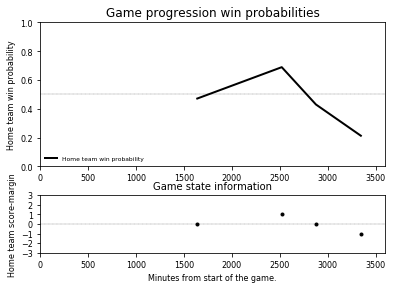

In [98]:
plt.rc('axes', grid=False)

width = 0.001
space = width + 0.10
left, width = 0.1, 0.8
rect1 = [left, 0.4, width, 0.5]
rect2 = [left, 0.1, width, 0.2]

fig = plt.figure(facecolor='white')
ax1 = fig.add_axes(rect1, facecolor='white')
ax2 = fig.add_axes(rect2, facecolor='white', sharex=ax1)

ax1.tick_params(axis='y', labelsize=8)
ax1.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.tick_params(axis='x', labelsize=8)
ax1.set_ylim([0,1])
ax2.set_ylim([-3, 3])
ax1.set_xlim([0,3600])
ax2.set_yticks(ticks=[-3, -2, -1, 0, 1, 2, 3])

# ig.suptitle(gameTitle, fontsize=12)
ax1.set_title("Game progression win probabilities", fontsize=12)
ax1.set_ylabel('Home team win probability', fontsize=8)
ax2.set_title('Game state information', fontsize=10, multialignment='center')
ax2.set_ylabel('Home team score-margin', fontsize=8, multialignment='center')
ax2.set_xlabel('Minutes from start of the game.', fontsize=8)

# plot lines
ax1.plot(d1['secstart'], d1['postprob']  , marker='', linestyle='-' , 
         linewidth=2, color='black',  
         label='Home team win probability')
ax1.axhline(y=.5, c="black", linewidth=0.25, linestyle='--', zorder=0)
ax2.plot(d1.secstart, d1.dgoals, '.', linewidth=0.5, color='black')
ax2.axhline(y=0, c="black", linewidth=0.25, linestyle='--', zorder=0)
legend = ax1.legend(loc='lower left', shadow=False, fontsize=6, frameon=False)



# save figure
# plt.savefig("gn500.pdf", format='pdf')
# plt.close('all')
plt.show()

In [87]:
help(ax2.set_ylim)

Help on method set_ylim in module matplotlib.axes._base:

set_ylim(bottom=None, top=None, emit=True, auto=False, **kw) method of matplotlib.axes._axes.Axes instance
    Set the data limits for the y-axis
    
    Parameters
    ----------
    bottom : scalar, optional
        The bottom ylim (default: None, which leaves the bottom
        limit unchanged).
    
    top : scalar, optional
        The top ylim (default: None, which leaves the top limit
        unchanged).
    
    emit : bool, optional
        Whether to notify observers of limit change (default: True).
    
    auto : bool or None, optional
        Whether to turn on autoscaling of the y-axis. True turns on,
        False turns off (default action), None leaves unchanged.
    
    ylimits : tuple, optional
        The bottom and top yxlims may be passed as the tuple
        (`bottom`, `top`) as the first positional argument (or as
        the `bottom` keyword argument).
    
    Returns
    -------
    ylimits : tuple
 